In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functions import *
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC

In [2]:
def merge_list(data):
    df = pd.merge(data[0], data[1], 'outer')
    for i in range(2, len(data)):
        df = pd.merge(df, data[i], 'outer')
    return df

def bookmaker_accuracy(df):
    """
    This function returns the accuracy of the bookmaker Interwetten (the one for which we have the most data).
    To compute the accuracy, we consider that for each game, the lowest odd proposed by the bookmaker corresponds
    to the most probable outcome according to the bookmaker. Hence, we compare the realized outcome with 
    the outcome implied by the lowest odd proposed by the bookmaker. The accuracy is then simply computed as 
    the number of correct outcomes divided by the number of total observations.
    """
    good_outcomes = []
    for i in range(len(df)):
        count = 0
        outcome = df['FTR'].iloc[i]
        min_odd = np.argmin(df[['IWH', 'IWD', 'IWA']].iloc[i])
        if min_odd == 'IWH' and outcome == 1 or min_odd == 'IWD' and outcome == 0 or min_odd == 'IWA' and outcome == 2:
            count = count + 1
        else:
            count = count
        good_outcomes.append(count)
    s = sum(good_outcomes)
    accuracy = s / len(df)
    
    return accuracy  

def choose_team(df, team, date):
    """
    Output: returns all the data of a certain team available at time t-1 to predict a game a time t.
    """
    return df.loc[((df['date'] < date) & (df['HomeTeam'] == team)) | (df['date'] < date) & (df['AwayTeam'] == team)]

def choose_hometeam(data, team):
    """
    Returns all available home games data for a certain team.
    """
    return data.loc[(data['HomeTeam'] == team)]

def choose_awayteam(data, team):
    """
    Returns all available away games data for a certain team.
    """
    return data.loc[(data['AwayTeam'] == team)]

def choose_game(data, date, hometeam, awayteam):
    """
    Returns the data of a specific game, with a certain home team, a certain away team, at a given date.
    """
    return data.loc[(data['Date'] == date) & (data['HomeTeam'] == hometeam) & (data['AwayTeam'] == awayteam)]

def find_games(data, team1, team2):
    """
        Returns all available games data between team1 and team2.
    """
    return data.loc[(data['HomeTeam'] == team1) & (data['AwayTeam'] == team2) | (data['HomeTeam'] == team2) & (data['AwayTeam'] == team1) ]

def F2F(data, team1, team2, date):
    """
    Returns all available historical data of games between two teams that occured before a certain date.
    """
    return data.loc[(data['date'] < date) & (data['HomeTeam'] == team1) & (data['AwayTeam'] == team2) | (data['date'] < date) & (data['HomeTeam'] == team2) & (data['AwayTeam'] == team1)]

def plot_bets_returns(sub_data, initial_investment, strategy):
    import random
    plt.rcParams['figure.figsize']=(8,4)
    plt.style.use('ggplot')
    
    gains=[0]
    bankroll = len(sub_data)
    pf = [bankroll]
    initial_investment = bankroll
    returns=[]
    for i in range(len(sub_data)):
        possible_outcomes = ['H', 'A', 'D']
        if strategy == 'Random':
            bet = random.choice(possible_outcomes)
        elif strategy == 'Home':
            bet = 'H'
        elif strategy == 'Draw':
            bet = 'D'
        elif strategy == 'Away':
            bet = 'A'
        elif strategy == 'Minimum Odd':
            idx = np.argmin(np.array([df['IWH'].iloc[i], df['IWD'].iloc[i], df['IWA'].iloc[i]]))
            if idx == 0:
                bet = 'H'
            elif idx == 1:
                bet = 'D'
            else:
                bet = 'A'
        result = sub_data['FTR'].iloc[i]
        winning_odd = 'IW' + result
        money = 0.01 * bankroll
    
        if bet == result:
            gain = money * (sub_data[winning_odd].iloc[i]-1)
        else:
            gain = -money
        bankroll = bankroll + gain
        pf.append(bankroll)
        rendement = (bankroll - initial_investment)/initial_investment
        gains.append(gain)
        returns.append(rendement)
        
    gains = pd.DataFrame(gains, columns=['Bets daily gains'])
    returns = pd.DataFrame(returns, columns=['Bets returns'])
    pf = pd.DataFrame(pf, columns=['Portfolio evolution'])
    
    
    returns.plot()
    plt.xlabel('Number of Bets')
    plt.ylabel('Cumulated Return')
    plt.title('Cumultated Return on Invested Capital for ' + strategy + ' Strategy')
    plt.savefig(strategy + '_strategy.png')

In [3]:
%%time
personnal_path = '/Users/allanbellahsene/Desktop/DATA_SCIENCE_PROJECT_ALLAN/'
common_path = 'data/PREMIER_LEAGUE/PL_'
path = personnal_path + common_path
years = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
         '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
data = import_data(init_path=path, years=years)
df = merge_list(data)
#For now, we select the features to keep manually, as they are the ones of interest for us (for now)
df = df[['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC'
          , 'HF', 'AF', 'IWH', 'IWD', 'IWA']]
df.dropna(axis=0,how='any',inplace=True)
df.reset_index(inplace=True)
df = df.drop(['index'], axis=1)
dates = []
for i in range(len(df)):
    date = df['Date'].iloc[i]
    try:   
        date = datetime.strptime(date, '%d/%m/%y')
    except:
        date = datetime.strptime(date, '%d/%m/%Y')   
    dates.append(date)
dates = pd.DataFrame(dates, columns=['Date'])
df['date'] = dates


CPU times: user 2.42 s, sys: 60.5 ms, total: 2.48 s
Wall time: 2.58 s


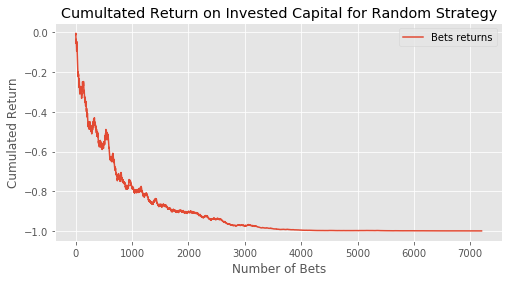

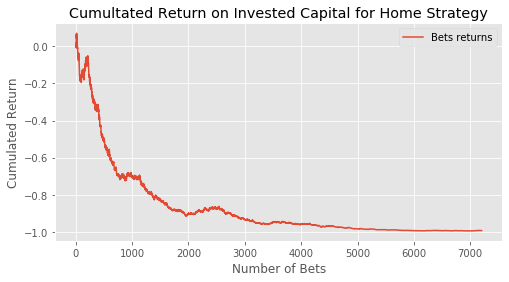

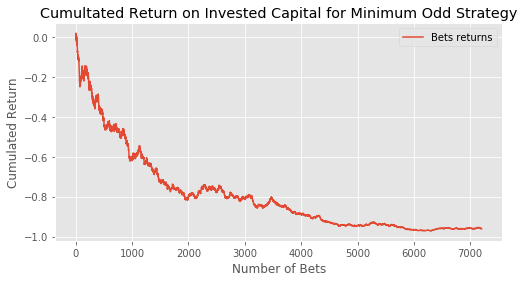

In [4]:
capital = 1000
for strategy in ['Random', 'Home', 'Minimum Odd']:
    plot_bets_returns(sub_data=df, initial_investment=capital, strategy=strategy)